# Define Problem
 Như đã đề cập vấn đề ở part 1 dự đoán giá bơ. Thì trong notebook này chúng ta thực hiện phân tích chuỗi thời gian cho thị trường bơ thông thường tại California. Để hiểu rõ hơn về khả năng mở rộng tại thị trường này.

Vậy nên trước khi bắt đầu triển khai chúng ta nên đặt ra một câu hỏi để nảy nở ra một giả thuyết.
Theo yêu cầu của bài toán này, chúng ta sẽ dự đoán giá bơ hữa cơ tại California trong tương lại gần nhằm mục đích để chứng minh là công ty có thể mở rộng tại thị trường này.

Vậy câu hỏi đặt ra ở đây là giá bơ có liên quan gì đến việc mở rộng của công ty?

Có vài giả thuyết cho câu hỏi trên:
Cung với cầu là hai yếu tố ảnh hưởng đến giá cả của một sản phẩm trên thị trường. Khi cung tăng thì giá giảm, ngược lại khi cầu tăng thì giá cũng sẽ tăng. Ngoài ra cung và cầu cũng ảnh hưởng qua lại với nhau theo tỉ lệ nghịch. Vì thế việc giá cả biến động là do hai yếu tố này gây nên.
Trường hợp lý tưởng nhất là do nhu cầu thị trường đang tăng cao khiến giá cả quả bơ tăng cao, từ đó chúng ta có thể triển khai mở rộng thị trường. Trường hợp không liên quan nhất là do số lượng sản phẩm cung cấp trong thị trường giảm mạnh, có thể là do vấn đề về phía doanh nghiệp.

Việc chúng ta thật sự quan tâm ở đây, là thiên thời, tức là thời thế mà nhu cầu sản phẩm của chúng ta tăng mạnh. Như có một xu hướng tăng cân trong xã hội, thời gian vàng của doanh nghiệp hoặc một cái gì đấy tương tự. Vậy nên việc nhu cầu thì trường tăng cao khiến giá bơ tăng cao là một yếu tố quyết liệt để chúng ta có thể đưa ra quyết định mở rộng doanh nghiệp.
Trong khi đó, việc giá bơ tăng cao do việc cung vào thị trường giảm, là một yếu tố nằm về phía doanh nghiệp. Vì thế chúng ta cần phải xác định được vấn đề đấy nó nằm ở đâu bên trong hệ thống phân phối sản phẩm của công ty, để mà giải quyết vấn đề đấy. Và do đó việc triển khai mở rộng không liên quan gì với trường hợp này.

Vì thế bài toán không chỉ dừng lại ở mức dự đoán giá cả của quả bơ tại các cửa hàng. Mà xa hơn nữa, chúng ta cần phải tìm các yếu tố khác nằm bên trong thị trường, nằm bên trong doanh nghiệp của chúng ta, trước khi đưa ra bất kì quyết định nào khác. Vậy nên chúng ta cần nhiều thông tin hơn thế nữa, tuy nhiên điều đó đã vượt qua giới hạn phạm vi của yêu cầu bài toán đã đưa ra.

Trường hợp có thể xác định rõ hơn là chúng ta nhìn vào doanh thu của doanh nghiệp, tuy nhiên việc triển khai ý tưởng này sẽ lạc xa yêu cầu của đề bài, nên chúng ta không cân nhắc nó ở đây.



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import matplotlib.dates as mdates

#analysys
from statsmodels.tsa.seasonal import seasonal_decompose

#model
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet

#evalution model
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Custom CSS for data visualization
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.titlesize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

Importing plotly failed. Interactive plots will not work.


# Load data, cleaning data

In [2]:
#Load data
data = pd.read_csv('avocado.csv', index_col = 0)
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [3]:
#Select only avocado organic from California
df = data[(data['region'] == 'California') & (data['type'] == 'conventional')]
df.size

2197

In [4]:
#Select only columns data and averagePrice
df = df[['Date', 'AveragePrice']]
#Rename columns for fbprophet
df.columns = ['ds', 'y']
#Cast date object to datetime dtype
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,2015-12-27,0.90
1,2015-12-20,0.94
2,2015-12-13,0.87
3,2015-12-06,0.78
4,2015-11-29,0.91


In [5]:
#Check dupplicate
df.shape[0] == len(df.ds.unique())

True

=> Dữ liệu không bị trùng. Data nhìn có vẻ sạch rồi, chúng ta sẽ triển khai bước tiếp theo.

# Phân tích xu hướng

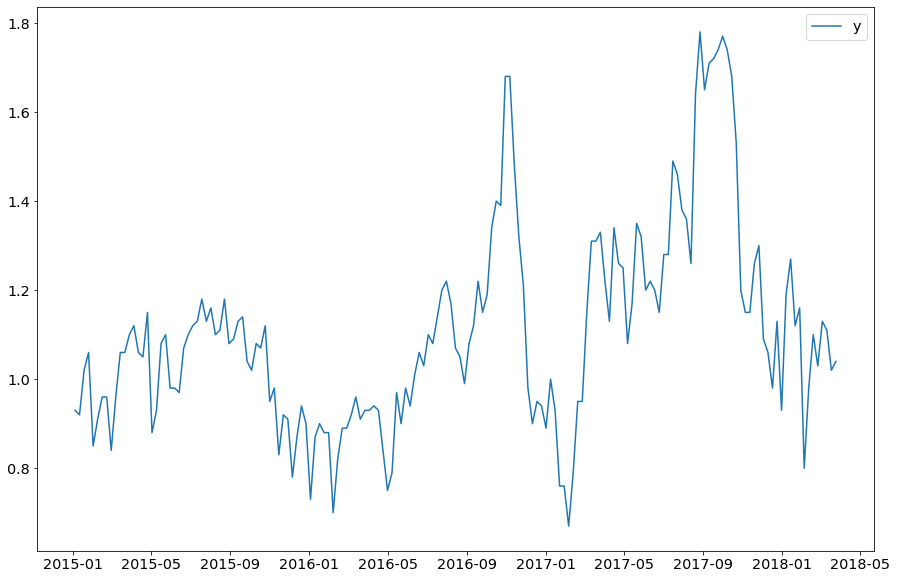

In [6]:
sns.lineplot(data = df.set_index(keys = 'ds')).set_xlabel('');

Dữ liệu kéo dài từ đầu năm 2015 đến giữa năm 2018.
Nhìn trên ta có thể thấy xu hướng dữ liệu có biến động rất lớn theo mùa. Và tăng mạnh từ đầu năm 2017. Có thể ví đường đi này giống như một ngọn sóng đang dâng trào.

In [7]:
df_index = df.set_index(keys = 'ds').sort_index()
df_index.head()

,y
ds,
2015-01-04,0.93
2015-01-11,0.92
2015-01-18,1.02
2015-01-25,1.06
2015-02-01,0.85


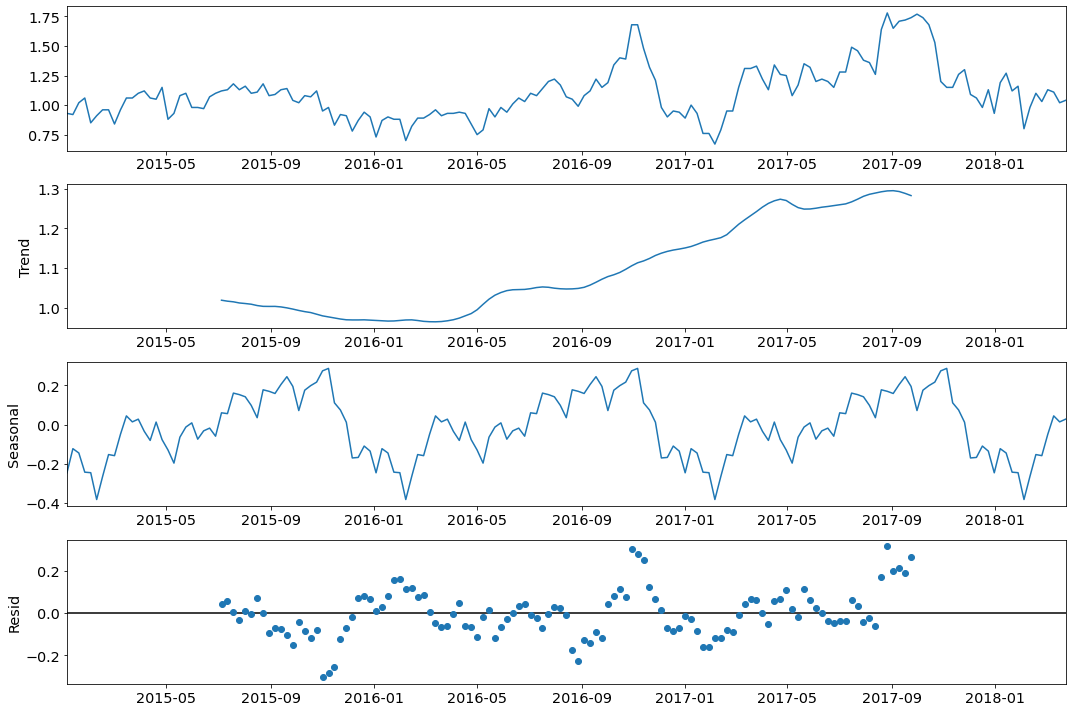

In [8]:
#Seasonal decompose analysys
seasonal_decompose(df_index , model = 'add').plot();

Từ biểu đồ Trend, chúng ta đã xác định rõ là dữ liệu sẽ tănng mạnh từ giữa năm 2016. Từ Resid, thì chúng ta phát hiện có điểm biến động mạnh vào tháng 10-11 năm 2016 và biến động mạnh vào tháng 9 2017. Hai tháng này đều nằm vào mùa thu trong năm. Chúng ta nên nghiên cứu kĩ hơn các yếu tố gây ra biến động này.
Ngoài ra giá tăng có xu hướng tăng theo mùa qua mỗi năm, biến động một cách đều đặng.

# Xây dựng model

In [9]:
import math
def time_series_split(df, train_size):
    total_rows = df.shape[0]

    ac_train_size = math.ceil(total_rows*train_size)

    train = df.iloc[:ac_train_size]
    test = df.iloc[ac_train_size:]

    return train, test

In [10]:
train_index, test_index = time_series_split(df_index, 0.8)
train, test = time_series_split(df, 0.8)
test_index.head()

,y
ds,
2017-08-13,1.26
2017-08-20,1.64
2017-08-27,1.78
2017-09-03,1.65
2017-09-10,1.71


In [11]:
test_index.tail()

,y
ds,
2018-02-25,1.03
2018-03-04,1.13
2018-03-11,1.11
2018-03-18,1.02
2018-03-25,1.04


## SARIMA

In [36]:
sarima_model = auto_arima(train_index, start_p=2, start_q=2,
                          max_p=5, max_q=5, m=12,
                          start_P=1, seasonal=True,
                          d=1, D=1, trace=True,
                          error_action='ignore',
                          suppress_warnings=True,
                          n_jobs= 4,
                          stepwise=True)

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\pmdarima\arima\_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=1.61 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-120.802, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-160.419, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-118.826, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-168.273, Time=0.27 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-170.152, Time=0.12 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-162.412, Time=0.09 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=-168.313, Time=0.23 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=-167.768, Time=0.70 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=-168.1

In [56]:
#Fit model
sarima_model.fit(train_index)
#Predict
test_forecast = sarima_model.predict(n_periods=len(test_index))
test_forecast = pd.DataFrame(test_forecast, index = test_index.index, columns = ['Prediction'])
test_forecast.tail()

,Prediction
ds,
2018-02-25,1.664138
2018-03-04,1.622368
2018-03-11,1.654012
2018-03-18,1.688929
2018-03-25,1.778042


In [57]:
#Save scoring
scoring = pd.DataFrame()
scoring.loc[0,'Aglothirm'] = 'SARIMA'
scoring.loc[0,'MSE on Test'] = mean_squared_error(test_index, test_forecast)
scoring

,Aglothirm,MSE on Test
0,SARIMA,0.216624


## HoltWinter

In [103]:
#Init and fit model
hwmodel = ExponentialSmoothing(train_index, trend='mul', seasonal='add').fit()
test_forecast = hwmodel.forecast(len(test))
#Forecast
test_forecast = pd.DataFrame(test_forecast, index = test_index.index, columns = ['Prediction'])
test_forecast.tail()

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


,Prediction
ds,
2018-02-25,1.003368
2018-03-04,1.118083
2018-03-11,1.216110
2018-03-18,1.197451
2018-03-25,1.222142


In [104]:
#Save scoring
scoring.loc[1,'Aglothirm'] = 'HoltWinter'
scoring.loc[1,'MSE on Test'] = mean_absolute_error(test_index, test_forecast)
scoring

,Aglothirm,MSE on Test
0,SARIMA,0.216624
1,HoltWinter,0.182539
2,Fbprophet,0.249293


## Fbprophet

In [41]:
CAP = 3.5
train['cap'] = CAP
test['cap']= CAP

C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
#Init model
m = Prophet(growth='logistic') #Turn on logistic because we saw the trend up above, it growth logistic
m.fit(train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [67]:
#Create future stream
future = m.make_future_dataframe(periods=12, freq='W')
future['cap']= CAP
future.tail()

,ds,cap
143,2018-02-25,3.5
144,2018-03-04,3.5
145,2018-03-11,3.5
146,2018-03-18,3.5
147,2018-03-25,3.5


In [68]:
#Forecast the unknown
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
143,2018-02-25,1.258482,1.088873,1.433718
144,2018-03-04,1.304983,1.130128,1.473631
145,2018-03-11,1.326411,1.133475,1.483154
146,2018-03-18,1.335354,1.172904,1.507370
147,2018-03-25,1.357115,1.179022,1.528857


In [63]:
test_index.index[0]

Timestamp('2017-08-13 00:00:00')

In [69]:
#Make a predict
predict = forecast[forecast['ds'] >= test_index.index[0]]
predict= predict[['ds', 'yhat']]
predict

,ds,yhat
115,2017-08-13,1.352881
116,2017-08-20,1.377194
117,2017-08-27,1.424848
118,2017-09-03,1.463950
119,2017-09-10,1.475273
120,2017-09-17,1.470746
121,2017-09-24,1.476899
122,2017-10-01,1.502573
123,2017-10-08,1.528114
124,2017-10-15,1.527436


In [105]:
#Save scoring
scoring.loc[2,'Aglothirm'] = 'Fbprophet'
scoring.loc[2,'MSE on Test'] = mean_absolute_error(test['y'], predict['yhat'])
scoring

,Aglothirm,MSE on Test
0,SARIMA,0.216624
1,HoltWinter,0.182539
2,Fbprophet,0.249293


In [48]:
test['y'].std()

0.18681997897830557

Vậy là SARIMA hoạt động tốt hơn hai thuật toán còn lại. Sai số là 0.18 khá khớp với biến động của dữ liệu thực tế là 0.19

# Báo cáo kết quả

In [106]:
#Holtwinter model from up above
test_forecast = hwmodel.forecast(len(test_index))
#Forecast
test_forecast = pd.DataFrame(test_forecast, index = test_index.index, columns = ['Prediction'])

In [50]:
365/7

52.142857142857146

In [107]:
#Init best_model
best_model = ExponentialSmoothing(df_index, trend='mul', seasonal='add').fit()
#Make a predict for next year
next_year = best_model.forecast(52)
next_year.tail()


C:\Users\PC\anaconda3\envs\dstn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  % freq, ValueWarning)


2019-02-24    0.721793
2019-03-03    0.832829
2019-03-10    0.901336
2019-03-17    0.864888
2019-03-24    0.888407
Freq: W-SUN, dtype: float64

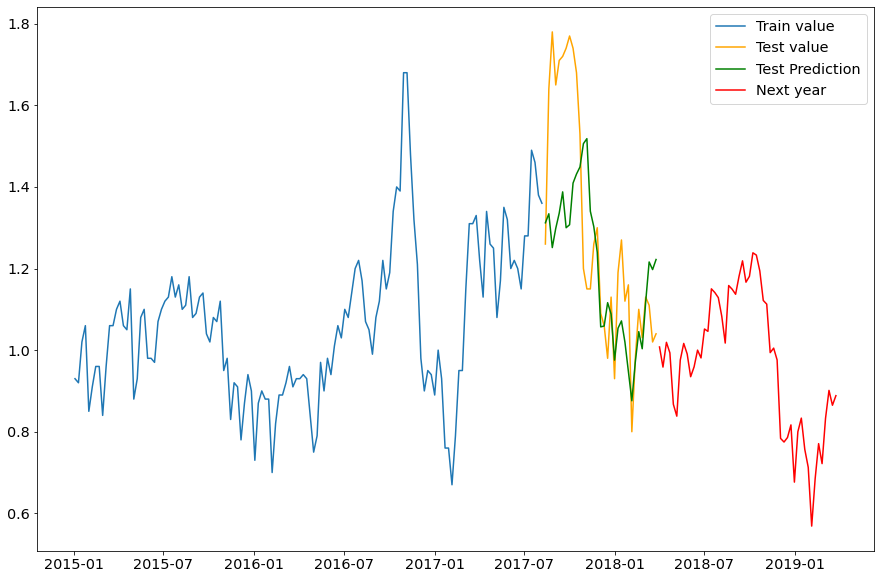

In [108]:
#Ploting
graph = plt.plot(train_index, label = 'Train value')
graph = plt.plot(test_index, label = 'Test value', color = 'orange')
graph = plt.plot(test_forecast, label = 'Test Prediction', color = 'green')
graph = plt.plot(next_year, label = 'Next year', color = 'red')
plt.legend()
plt.show()

Vì lý do gì đấy, mô hình HoltWinter dự đoán kết quả là trong năm tới là giá loại bơ thông thường cho xu hướng giảm so với năm 2017. Chúng ta hãy thử kiềm chứng với fbprophet.

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


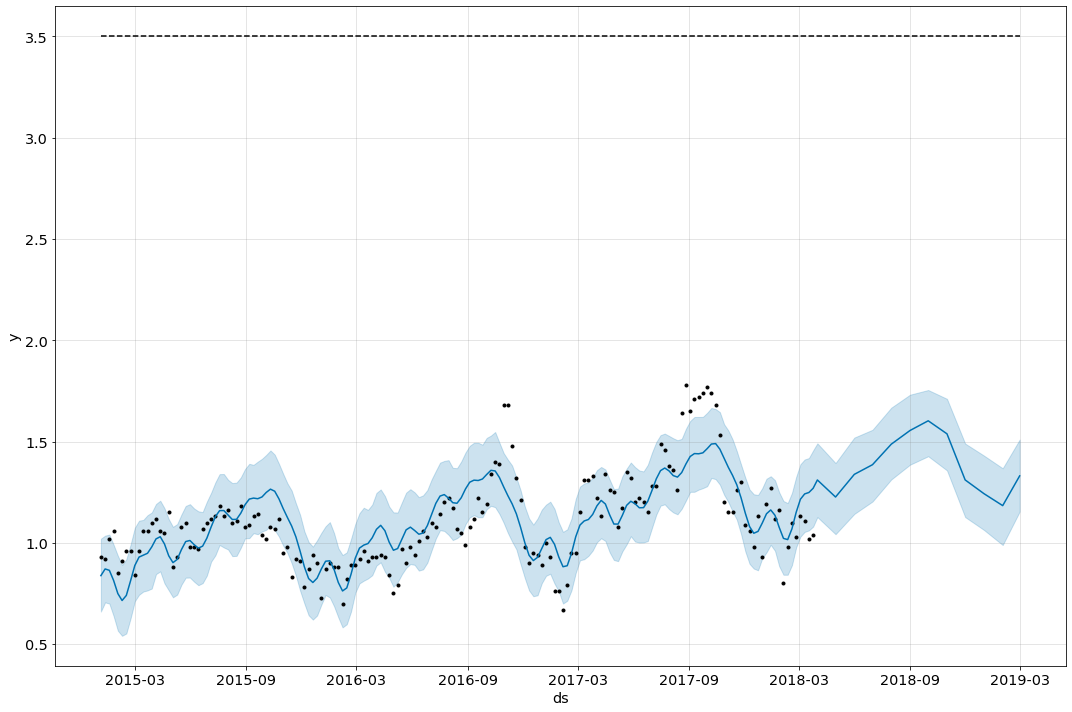

In [53]:
#Init model
df['cap'] = CAP
m = Prophet(growth='logistic') #Turn on logistic because we saw the trend up above, it growth logistic
m.fit(df)
#Create future stream
future = m.make_future_dataframe(periods=12, freq='MS', include_history=True)
future['cap']= CAP
#Forecast the unknown
forecast = m.predict(future)
#Take a look at the graph
m.plot(forecast, figsize=(15,10));

Nhìn đường đi của mô hình fbprophet, chúng ta có thể thấy là nó khá khớp so với dữ liệu thực tế. Vậy nên chỉ nhìn trên chỉ số MSE là không đủ để đánh giá model. Do đó kết quả dự đoán cuối cùng của sẽ dựa trên kết quả của mô hình này.

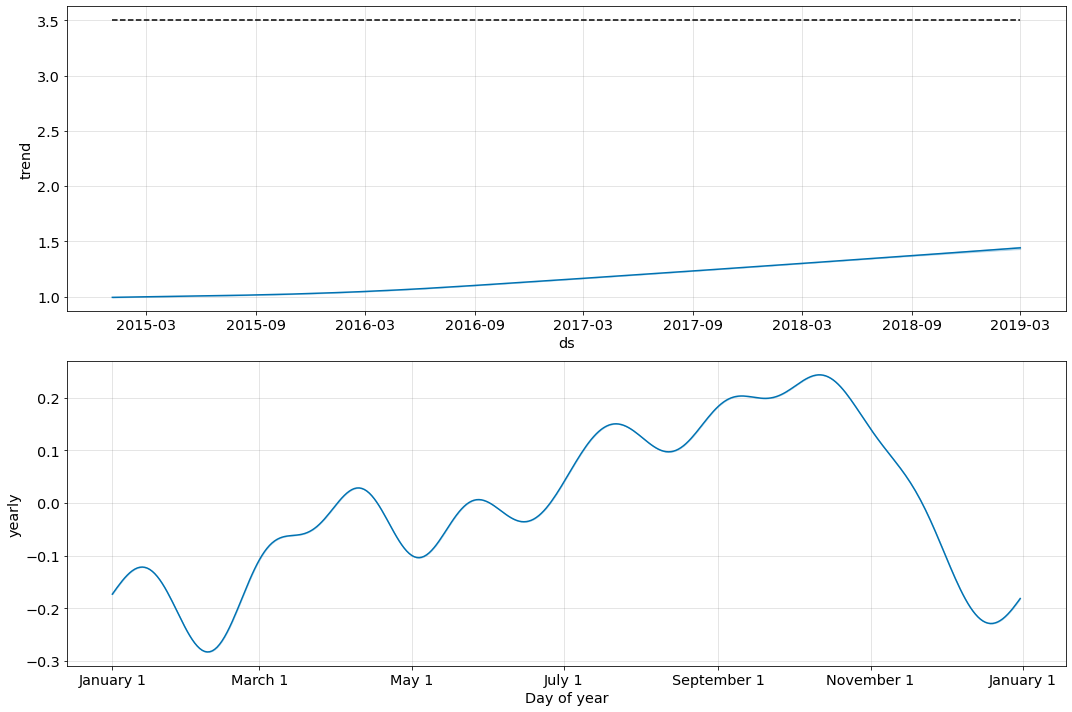

In [54]:
m.plot_components(forecast, figsize=(15,10));

Như chúng ta đã nói trong part một, giá bơ có xu hướng tăng mạnh vào đầu mùa thu. Giảm mạnh vào cuối mùa đông.
Và vậy là trong năm sau, giá của loại bơ thông thường cũng sẽ tăng như giá của bơ hữa cơ. Tổng giá dự đoán sẽ tăng là khoảng 30-40cent

## Tổng hợp

- Cũng như giá cả của bơ hữa cơ, bơ thông thường trong năm sau cũng cho ra kết quả tăng lên. Chúng ta có thể cân nhắc mở rộng tại bang này. Tuy nhiên biến động giá cả chưa chắc tượng chưng cho doanh thu của doanh nghiệp, vậy nên nếu có dữ liệu doanh thu tại các cửa hàng chúng ta sẽ cân nhắc cho ra một quyết định chính xác hơn.

- Ngoài ra, giá cả của bơ cũng biến động theo mùa, tăng mạnh vào mùa thu và giảm mạnh vào cuối mùa đông. Chúng ta nền cân nhắc mở một chiến dịch gì đấy.

- Một điều đáng lưu ý nữa là, giá cả của bơ tại năm 2017, 2016 có biến động mạnh, theo chiều hướng tăng. Vậy nên câu hỏi tiếp theo của chúng ta là tại sao nó lại biến động vào thời gian này? Yếu tố nào khiến nó biến động như vậy? Là một câu hỏi quan trọng để phát hiện những yếu tố tiềm năng để cải thiện cho doanh nghiệp sau này.